In [1]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols
import numpy as np
import rebound
import reboundx
from scipy.integrate import odeint
from sympy import init_printing
init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider

In [2]:
m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2 = symbols("m1, M1, mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2")

In [3]:
import math
import numpy as np

def LaplaceCoefficient(s,j,a,n):
    j = abs(j)
    outside = 1
    for k in range(j):
        outside *= s+k
    outside *= 2./math.factorial(j)*a**(j-n)
    cterm = 1.
    cbterm = 1.
    for k in range(n):
        cbterm *= (j-k)
    csum = cbterm
    i=1
    while cbterm > np.finfo(float).eps or cbterm == 0:
        cterm = cterm*(s+i-1)*(s+j+i-1)/i/(j+i)*a**2
        cbterm = cterm
        for k in range(n):
            cbterm *= j+2*i-k
        csum += cbterm
        i+=1
    return outside*csum

In [4]:
m=2 #m+1:m resonance
alpha = (m/(m+1))**(2/3)

In [5]:
Tf27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))*sqrt(2*Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1)
Tf31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2)
H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
Hres = H0 - m1/M1*mu2/Lambda2**2*(Tf27 + Tf31)

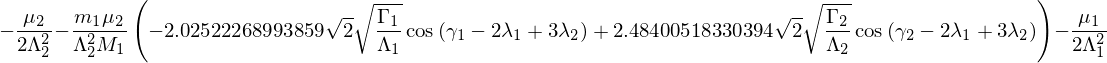

In [6]:
Hres

In [7]:
var = (m1, M1, mu1, mu2, lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2)
params = (m1, M1, mu1, mu2)
lambda1dotres = lambdify(var, diff(Hres, Lambda1), 'numpy')
lambda2dotres = lambdify(var, diff(Hres, Lambda2), 'numpy')
Lambda1dotres = lambdify(var, -diff(Hres, lambda1), 'numpy')
Lambda2dotres = lambdify(var, -diff(Hres, lambda2), 'numpy')
gamma1dotres = lambdify(var, diff(Hres, Gamma1), 'numpy')
gamma2dotres = lambdify(var, diff(Hres, Gamma2), 'numpy')
Gamma1dotres = lambdify(var, -diff(Hres, gamma1), 'numpy')
Gamma2dotres = lambdify(var, -diff(Hres, gamma2), 'numpy')
def diffeqres(y, t, *params):
    lambda1, lambda2, Lambda1, Lambda2, gamma1, gamma2, Gamma1, Gamma2 = y
    var = np.concatenate((params,y))
    dydt = [lambda1dotres(*var), lambda2dotres(*var), Lambda1dotres(*var), Lambda2dotres(*var), gamma1dotres(*var), gamma2dotres(*var), Gamma1dotres(*var), Gamma2dotres(*var)]
    return dydt

In [8]:
def mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return Mint*self.m/(Mint+self.m)

def Mjac(self):
    Mint = 0
    for i in range(self.index):
        Mint += self._sim.contents.particles[i].m
    return (Mint+self.m)/Mint*self._sim.contents.particles[0].m

def Lambda(self):
    return self.mjac*np.sqrt(self._sim.contents.G*self.Mjac*self.a)

def Gamma(self):
    return self.Lambda*(1.-np.sqrt(1.-self.e**2))

def gamma(self):
    return -self.pomega

def J(self):
    if self.hash == 1:
        return self.Lambda + m*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    if self.hash == 2:
        return self.Lambda - (m+1)*(self._sim.contents.particles[1].Gamma + self._sim.contents.particles[1].Gamma)
    
def mu(self):
    return self._sim.contents.G**2*self.Mjac**2*self.mjac**3

def phi(self):
    return (m+1)*self._sim.contents.particles[2].l - m*self._sim.contents.particles[1].l - self.pomega

rebound.Particle.mjac = property(mjac)
rebound.Particle.Mjac = property(Mjac)
rebound.Particle.Lambda = property(Lambda)
rebound.Particle.J = property(J)
rebound.Particle.mu = property(mu)
rebound.Particle.phi = property(phi)
rebound.Particle.Gamma = property(Gamma)
rebound.Particle.gamma = property(gamma)

def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

In [9]:
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 1000 # number of inner planet orbits to integrate for
Nout = 10000 # number of output points

In [10]:
mass = 1.5e-5 # solar masses
logmass = np.log10(mass)
delta = (1-alpha)/alpha*(2/3*10**logmass)**(-1/3)
print(10**logmass)
print(delta)

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m+1)/m)
sim.move_to_com()
ps = sim.particles

deltan = 2*np.pi/ps[1].P-2*np.pi/ps[2].P
prefac = ps[2].mu/ps[2].Lambda**2*ps[1].m/ps[0].m
s=0
for j in range(1,150):
    s += LaplaceCoefficient(0.5, j, alpha, 0)
s -= alpha
s = s/deltan
s = s*prefac
print(s)

1.5e-05
14.4061316196
7.21597025612e-09


In [29]:
sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m+1)/m)
sim.move_to_com()
ps = sim.particles

y0 = (ps[1].l, ps[2].l, ps[1].Lambda, ps[2].Lambda, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
y0offset = (ps[1].l, ps[2].l, ps[1].Lambda-s, ps[2].Lambda+s, ps[1].gamma, ps[2].gamma, ps[1].Gamma, ps[2].Gamma)
params0 = (ps[1].m, ps[0].m, ps[1].mu, ps[2].mu)
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)

Nlambda1, Nlambda2, NLambda1, NLambda2, Ngamma1, Ngamma2, NGamma1, NGamma2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Nphi1, Nphi2, Nh1, Nk1, Nh2, Nk2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    orbits = sim.calculate_orbits(heliocentric=True)
    sim.integrate(time)
    Nlambda1[i] = orbits[0].l
    Nlambda2[i] = orbits[1].l
    NLambda1[i] = ps[1].m*np.sqrt(sim.G*ps[0].m*orbits[0].a)
    NLambda2[i] = ps[2].m*np.sqrt(sim.G*ps[0].m*orbits[1].a)
    Ngamma1[i] = -orbits[0].pomega
    Ngamma2[i] = -orbits[1].pomega
    NGamma1[i] = NLambda1[i]*(1.-np.sqrt(1.-orbits[0].e**2))
    NGamma2[i] = NLambda2[i]*(1.-np.sqrt(1.-orbits[1].e**2))
    Nphi1[i] = ps[1].phi
    Nphi2[i] = ps[2].phi
    Nh1[i] = ps[1].e*np.cos(Nphi1[i])
    Nk1[i] = ps[1].e*np.sin(Nphi1[i])
    Nh2[i] = ps[2].e*np.cos(Nphi2[i])
    Nk2[i] = ps[2].e*np.sin(Nphi2[i])

Nlambda1=npwrap(Nlambda1)
Nlambda2=npwrap(Nlambda2)
Ngamma1=npwrap(Ngamma1)
Ngamma2=npwrap(Ngamma2)
Nphi1 = npwrap(Nphi1)
Nphi2 = npwrap(Nphi2)

solres = odeint(diffeqres, y0offset, times, args=params0)
Hlambda1res = npwrap(solres[:,0])
Hlambda2res = npwrap(solres[:,1])
HLambda1res = solres[:,2]
HLambda2res = solres[:,3]
Hgamma1res = npwrap(solres[:,4])
Hgamma2res = npwrap(solres[:,5])
HGamma1res = solres[:,6]
HGamma2res = solres[:,7]
Hphi1res = npwrap((m+1)*Hlambda2res - m*Hlambda1res + Hgamma1res)
Hphi2res = npwrap((m+1)*Hlambda2res - m*Hlambda1res + Hgamma2res)
Hh1res = np.sqrt(2.*HGamma1res/HLambda1res)*np.cos(Hphi1res)
Hk1res = np.sqrt(2.*HGamma1res/HLambda1res)*np.sin(Hphi1res)
Hh2res = np.sqrt(2.*HGamma2res/HLambda2res)*np.cos(Hphi2res)
Hk2res = np.sqrt(2.*HGamma2res/HLambda2res)*np.sin(Hphi2res)

sim = rebound.Simulation()
sim.G = 4*np.pi**2
rebx = reboundx.Extras(sim)
rebx.add("radial_force")
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m+1)/m)
sim.move_to_com()
ps = sim.particles
gamma = -1.5
pomegadotlibration = 1.8e-2
D=0.01
ps[0].params["gammaradial"] = gamma
ps[0].params["Aradial"] = rebx.radial_force_Aradial(p = ps[1], primary=ps[0], pomegadot=-D*pomegadotlibration, gamma=gamma)

Nlambda1p, Nlambda2p, NLambda1p, NLambda2p, Ngamma1p, Ngamma2p, NGamma1p, NGamma2p = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
Nphi1p, Nphi2p, Nh1p, Nk1p, Nh2p, Nk2p = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    orbits = sim.calculate_orbits(heliocentric=True)
    sim.integrate(time)
    Nlambda1p[i] = orbits[0].l
    Nlambda2p[i] = orbits[1].l
    NLambda1p[i] = ps[1].m*np.sqrt(sim.G*ps[0].m*orbits[0].a)
    NLambda2p[i] = ps[2].m*np.sqrt(sim.G*ps[0].m*orbits[1].a)
    Ngamma1p[i] = -orbits[0].pomega
    Ngamma2p[i] = -orbits[1].pomega
    NGamma1p[i] = NLambda1p[i]*(1.-np.sqrt(1.-orbits[0].e**2))
    NGamma2p[i] = NLambda2p[i]*(1.-np.sqrt(1.-orbits[1].e**2))
    Nphi1p[i] = ps[1].phi
    Nphi2p[i] = ps[2].phi
    Nh1p[i] = ps[1].e*np.cos(Nphi1p[i])
    Nk1p[i] = ps[1].e*np.sin(Nphi1p[i])
    Nh2p[i] = ps[2].e*np.cos(Nphi2p[i])
    Nk2p[i] = ps[2].e*np.sin(Nphi2p[i])

Nlambda1p=npwrap(Nlambda1p)
Nlambda2p=npwrap(Nlambda2p)
Ngamma1p=npwrap(Ngamma1p)
Ngamma2p=npwrap(Ngamma2p)
Nphi1p = npwrap(Nphi1p)
Nphi2p = npwrap(Nphi2p)

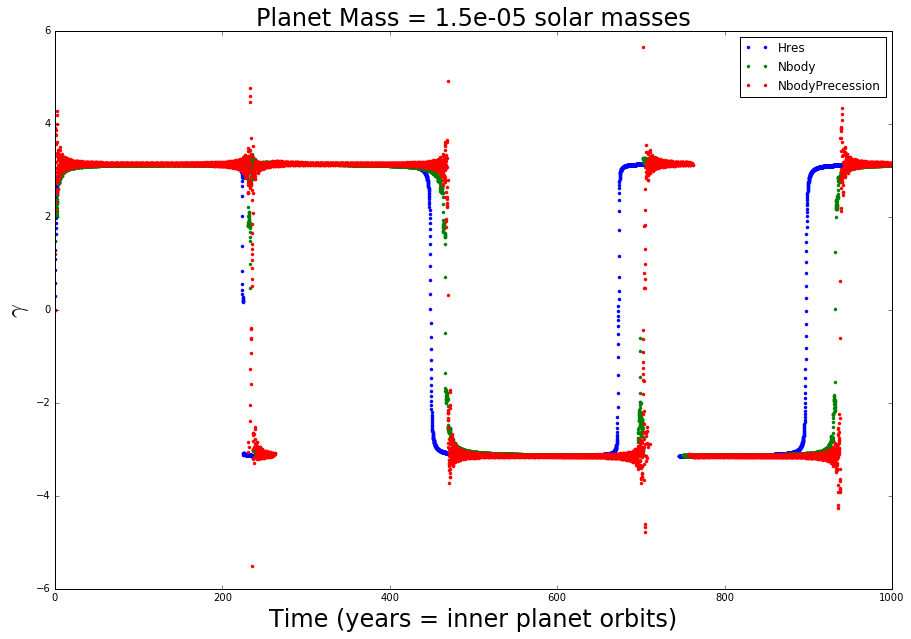

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\gamma$", fontsize=24)

ax.plot(times, Hgamma1res-Hgamma2res, '.', label='Hres')
ax.plot(times, Ngamma1-Ngamma2, '.', label='Nbody')
ax.plot(times, Ngamma1p-Ngamma2p, '.', label='NbodyPrecession')

ax.legend()

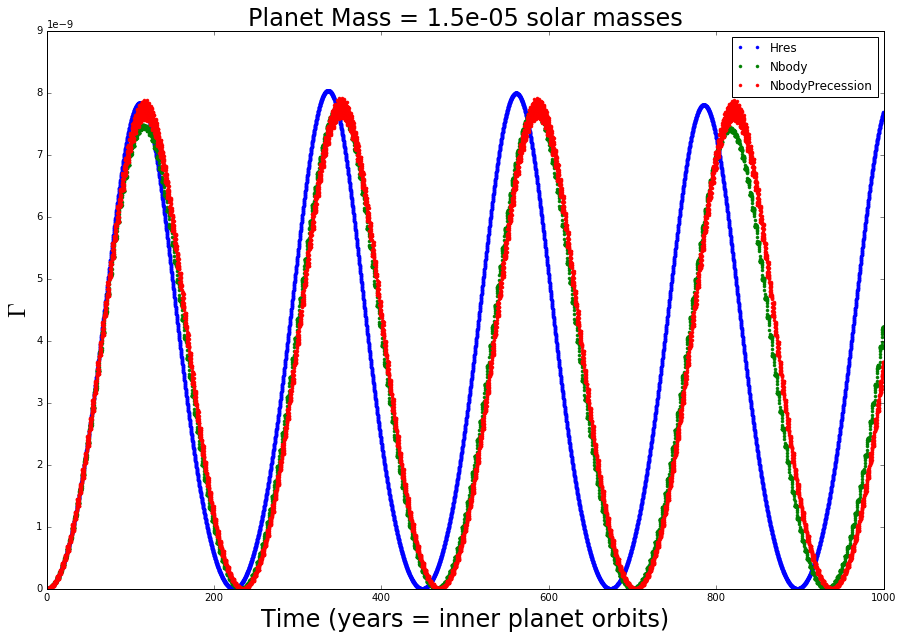

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Gamma$", fontsize=24)

ax.plot(times, HGamma1res, '.', label='Hres')
ax.plot(times, NGamma1, '.', label='Nbody')
ax.plot(times, NGamma1p, '.', label='NbodyPrecession')

ax.legend()

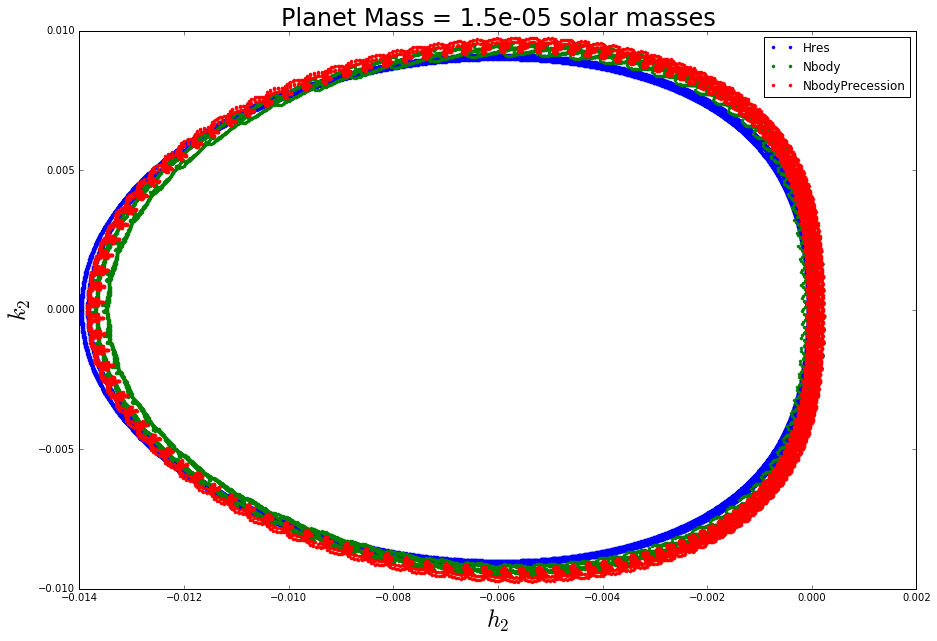

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("$h_2$", fontsize=24)
ax.set_ylabel(r"$k_2$", fontsize=24)

imin=0
imax=Nout#3500
ax.plot(Hh2res[imin:imax], Hk2res[imin:imax], '.', label='Hres')
ax.plot(Nh2[imin:imax], Nk2[imin:imax], '.', label='Nbody')
ax.plot(Nh2p[imin:imax], Nk2p[imin:imax], '.', label='NbodyPrecession')

ax.legend()